# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

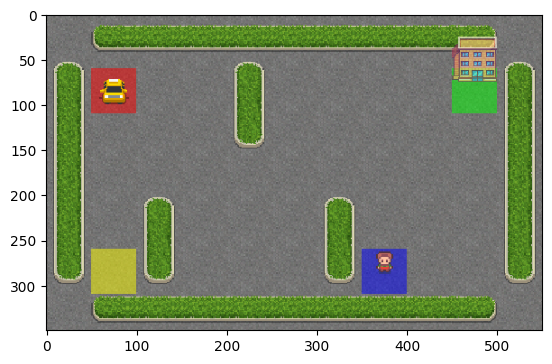

n_states=500, n_actions=6


In [87]:
import os
import gymnasium as gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n

plt.imshow(env.render())
plt.show()
print("n_states=%i, n_actions=%i"%(n_states,n_actions))

# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [88]:
policy = np.ones((n_states,n_actions))/n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [89]:
def generate_session(policy,t_max=10**4):
    states,actions = [],[]
    total_reward = 0.
    
    p = env.reset()
    s = int(p[0])
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s,r,term1,term2,info = env.step(a)
        done = term1 | term2
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [90]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]

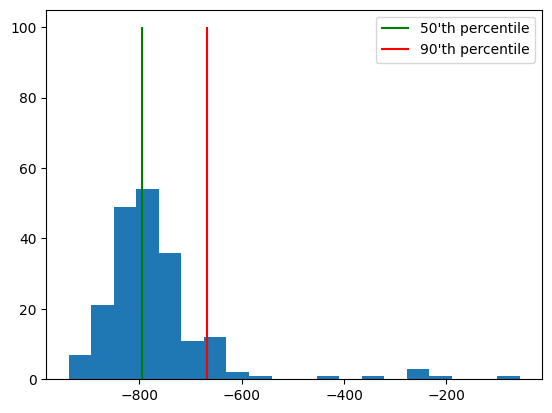

In [91]:
#let's see the initial reward distribution


sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [92]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile):
    
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if (rewards_batch[i] >= reward_threshold):
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states,elite_actions

    
states_batch = ([
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1]),     #game3
])

actions_batch = ([
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
])
rewards_batch = ([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert (test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and (test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3])
assert (test_result_40[0] == [4, 2, 0, 2, 3, 1]) and (test_result_40[1] ==[3, 2, 0, 1, 3, 3])
assert (test_result_90[0] == [3,1]) and (test_result_90[1] == [3,3])
assert (test_result_100[0] == [3,1]) and (test_result_100[1] == [3,3])
print("Ok!")


Ok!


In [93]:
def update_policy(elite_states,elite_actions):
    global n_states, n_actions
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    for i in range(len(elite_states)):
        new_policy[elite_states[i],elite_actions[i]] += 1
    for state in range(n_states):
        cnt = np.sum(new_policy[state,:])
        if (cnt == 0):
            new_policy[state,:] = 1.0 / n_actions
        else:
            new_policy[state,:] /= cnt
    return new_policy

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

mean reward = -218.160, threshold=8.300


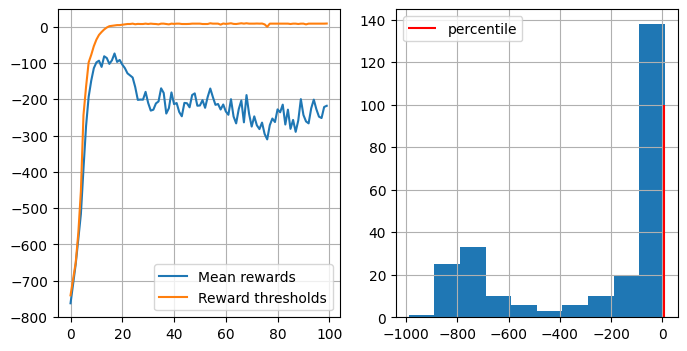

In [94]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()
    
n_sessions = 300  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites((states_batch),(actions_batch),(rewards_batch),percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = (1 - learning_rate) * policy + learning_rate * new_policy
    
    show_progress(rewards_batch,log)


# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [95]:
import gym
import numpy as np, pandas as pd

np.bool8 = np.bool_
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)

policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 40

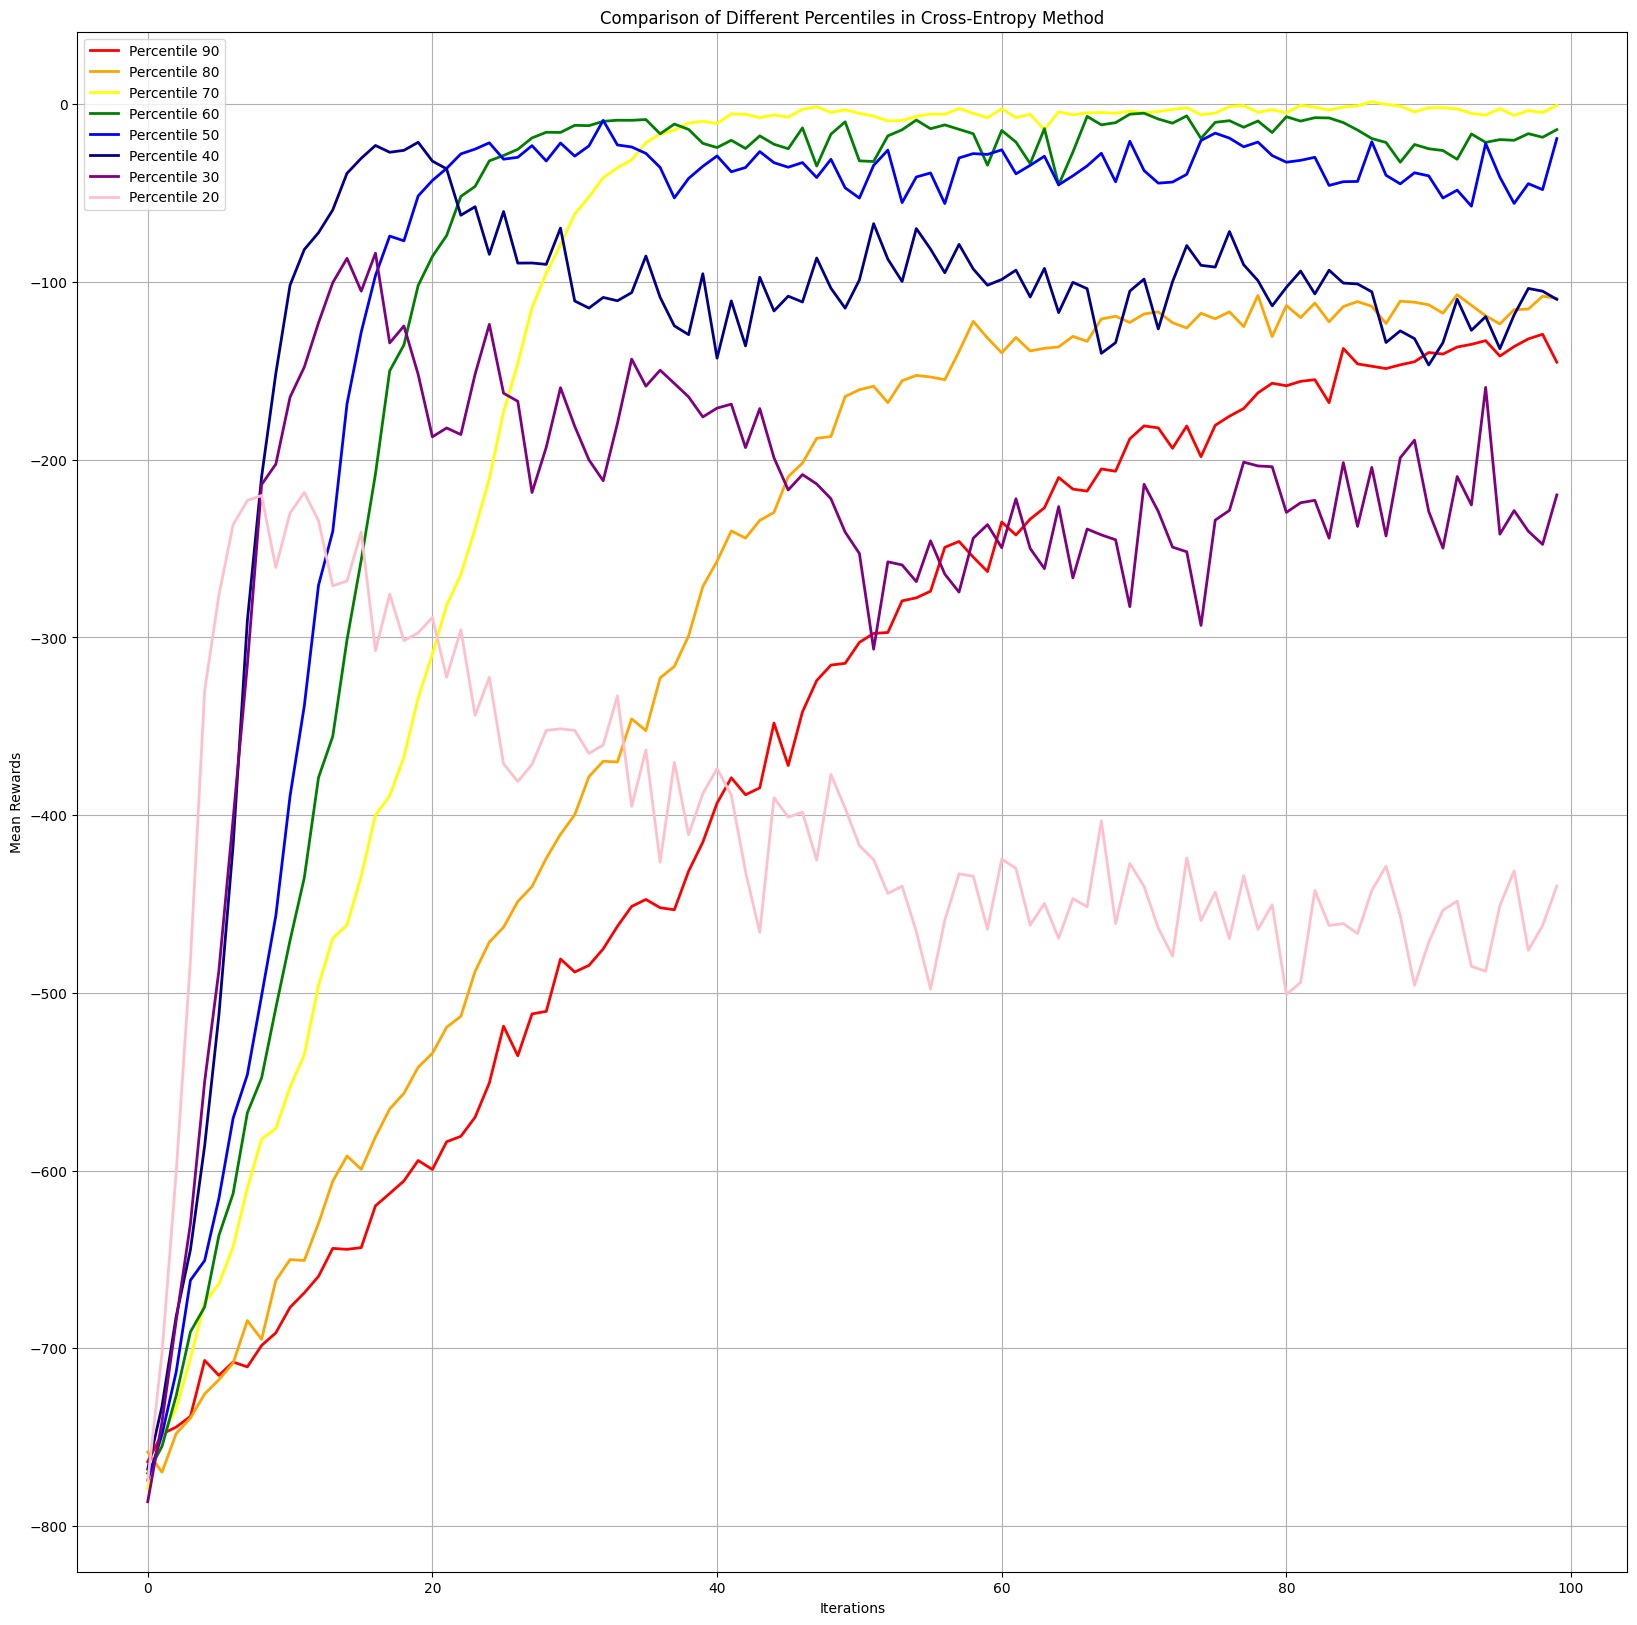

In [96]:
from matplotlib.ticker import MultipleLocator

n_sessions = 250 
percentiles = [10,20,30,40,50,60,70,80]
colors = ['red','orange','yellow','green','blue','darkblue','purple','pink']
learning_rate = 0.5

plot,plotGraphick = plt.subplots(figsize=(20,20))
plotGraphick.set_xlabel('Iterations')
plotGraphick.set_ylabel('Mean Rewards')
stepCounter = 100

log = []
mean = []
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites((states_batch),(actions_batch),(rewards_batch),percentile)

        new_policy = update_policy(elite_states,elite_actions)
        policy = (1 - learning_rate)*policy + learning_rate*new_policy
        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)
    plotGraphick.plot(range(stepCounter), curMean, label=f'Percentile {100-percentile}', 
            color=colors[percentiles.index(percentile)], linewidth=2)
plotGraphick.legend()
plotGraphick.grid(True)
plotGraphick.set_title('Comparison of Different Percentiles in Cross-Entropy Method')
plt.show()

# How do different percentiles affect training efficiency?

**Аналитика результатов**:

*Низкие перцентили* (10-30): быстрое обучение, но возможна нестабильность

*Средние перцентили* (40-60): баланс скорости и стабильности

*Высокие перцентили* (70-80): медленное, но стабильное обучение

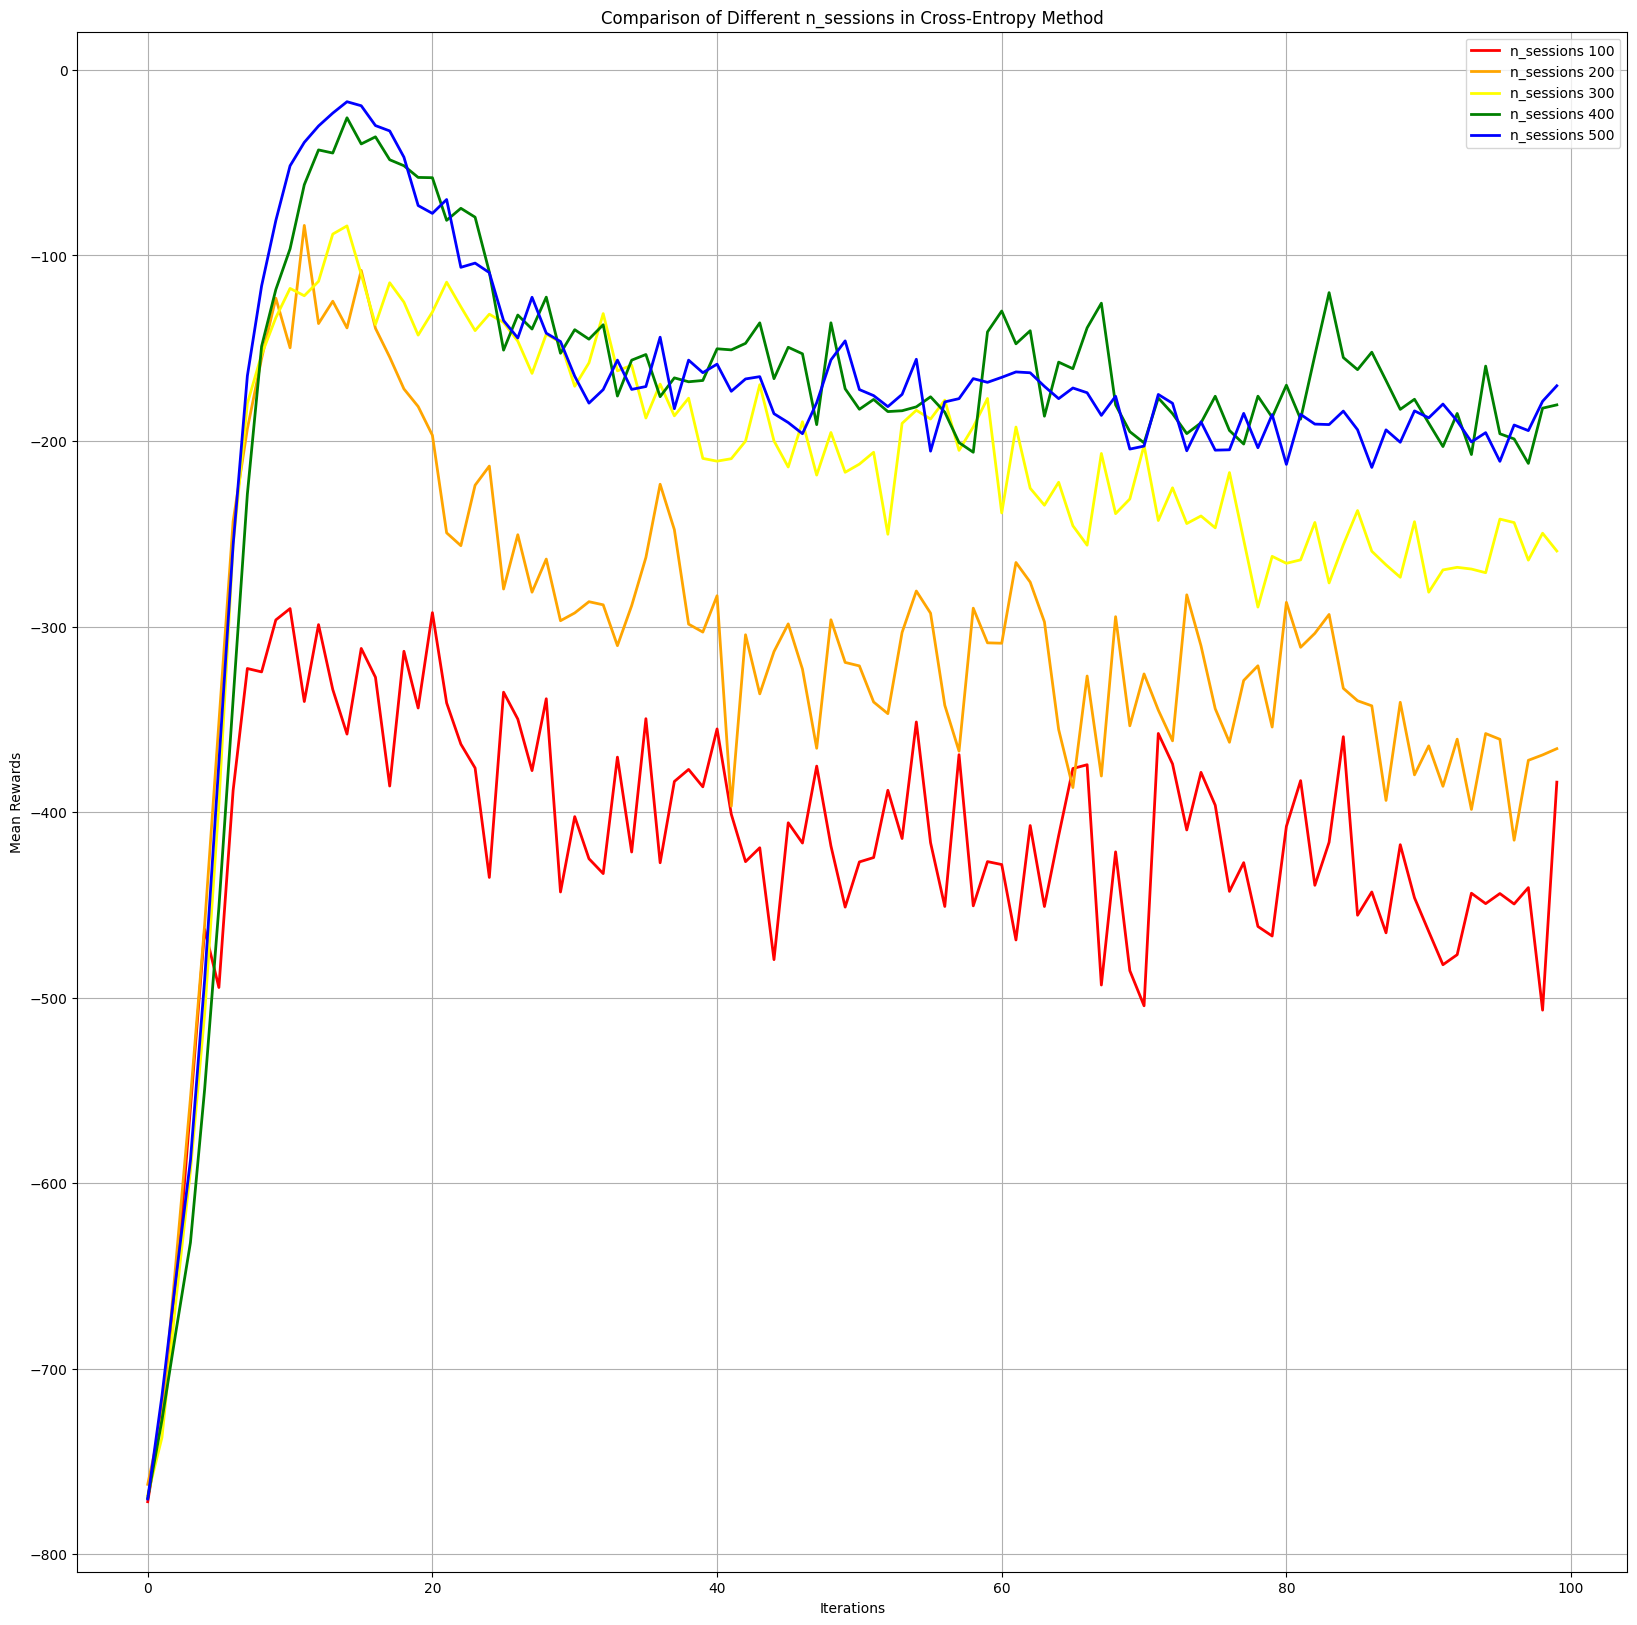

In [97]:
n_sessions_ar = [100,200,300,400,500]
perc = 70 
learning_rate = 0.5 
plot,plotGraphick = plt.subplots(figsize=(20,20))
plotGraphick.set_xlabel('Iterations')
plotGraphick.set_ylabel('Mean Rewards')
stepCounter = 100
log = []
mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites((states_batch),
                                                    (actions_batch),(rewards_batch),percentile=perc)

        new_policy = update_policy(elite_states,elite_actions)
        policy = (1 - learning_rate)*policy + learning_rate*new_policy
        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)
    plotGraphick.plot(range(stepCounter), curMean, label=f'n_sessions {n_sessions}', 
            color=colors[n_sessions_ar.index(n_sessions)], linewidth=2)
plotGraphick.legend()
plotGraphick.grid(True)
plotGraphick.set_title('Comparison of Different n_sessions in Cross-Entropy Method')
plt.show()

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [98]:
import os
import gymnasium as gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    p= env.reset()
    s = int(p[0])
    for i in range(10):
        for t in range(t_max):
            a = np.random.choice(range(n_actions), p = policy[s])
            
            new_s,r,term1,term2,info = env.step(a)
            done = term1 | term2
            states.append(s)
            actions.append(a)
            total_reward += r
            
            s = new_s
            if done:
                break
    return states,actions,total_reward/10.0
        

mean reward = 7.428, threshold=6.900


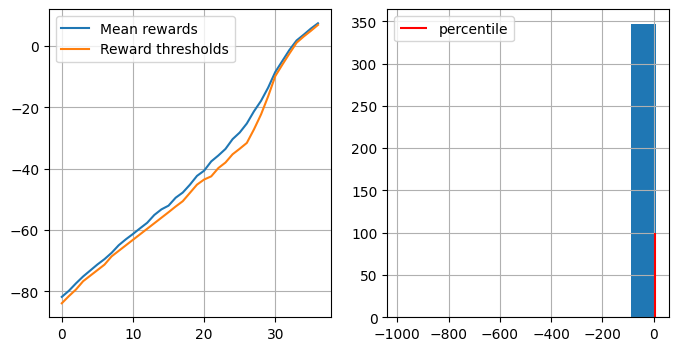

win!


In [101]:
n_sessions = 500
percentile = 40 
learning_rate = 0.5
stepCounter = 300
log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(1000):

    sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites((states_batch),(actions_batch),(rewards_batch),percentile)

    new_policy = update_policy(elite_states,elite_actions)
    policy = policy*(1-learning_rate) + new_policy*learning_rate

    show_progress(rewards_batch,log)
    
    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

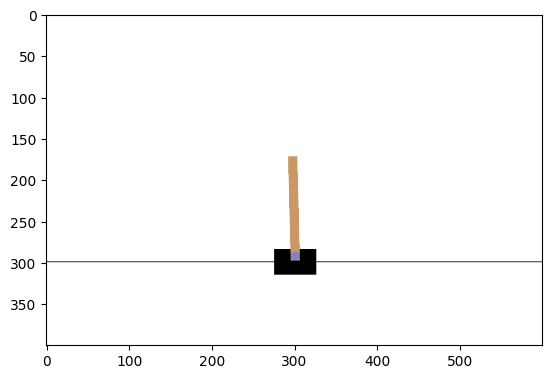

In [ ]:
import gymnasium as gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def show(title=""):
    global env
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

env = gym.make("CartPole-v1", render_mode="rgb_array") 

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render())

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [ ]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )

agent.fit([env.reset()[0]]*n_actions,range(n_actions));


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()[0]
    
    for t in range(t_max):
        
        #predict array of action probabilities hint: predict_proba
        probs = agent.predict_proba([s])[0]
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,term1,term2,info = env.step(a)
        done = term1 | term2
        
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done: break
    return states,actions,total_reward
s,a,r = generate_session()
print(r)

14.0


In [ ]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile):
    
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if (rewards_batch[i] >= reward_threshold):
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states,elite_actions
    

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

mean reward = 206.190, threshold=187.000


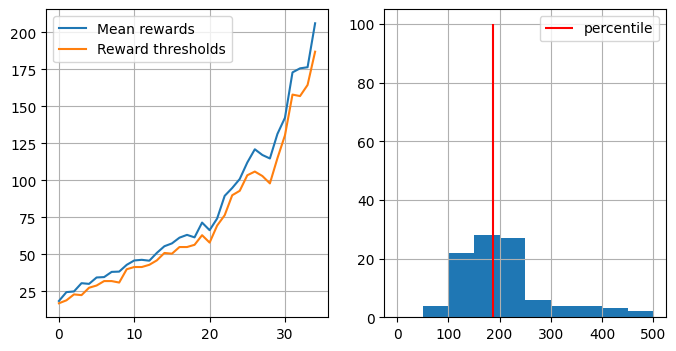

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
n_sessions = 100
percentile = 50
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)
    #print(states_batch.shape)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)
    
    #fit agent
    agent.fit(elite_states, elite_actions)
    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Report (1 pts)

# **Отчет**:

#### 1 Часть:

Я узнал, что такое среды *Taxi-v3* и *CartPole-v1*, научился работать с ними в какой-то мере и проанализировал при каких перцентилях и кол-во итерациях обучение проходит быстрее, а при каких медленнее. Построил графики зависимости.

#### 2 Часть: 

Я обучал агента с помощью встроенной нейронки, mean reward резко поднялся.